In [55]:
import pandas as pd

# Load test data
test = pd.read_csv("test_data.csv")

# Identify call and put IV columns
call_iv_cols = [col for col in test.columns if col.startswith("call_iv_")]
put_iv_cols = [col for col in test.columns if col.startswith("put_iv_")]

# Calculate number of non-NaN values per row for each
test['call_iv_count'] = test[call_iv_cols].notna().sum(axis=1)
test['put_iv_count'] = test[put_iv_cols].notna().sum(axis=1)

# Calculate the average across all rows
avg_call_iv_present = test['call_iv_count'].mean()
avg_put_iv_present = test['put_iv_count'].mean()

print(f"Average number of call IV values per row: {avg_call_iv_present:.2f}")
print(f"Average number of put IV values per row: {avg_put_iv_present:.2f}")


Average number of call IV values per row: 10.41
Average number of put IV values per row: 10.38


In [78]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('v3.csv')

# Count null values per column
null_counts = df.isnull().sum()

# Print the result
print("Null values per column:")
print(null_counts)

# Optionally, total null values in the entire DataFrame
total_nulls = df.isnull().sum().sum()
print(f"\nTotal null values in the entire CSV: {total_nulls}")


Null values per column:
timestamp        0
call_iv_24000    0
call_iv_24100    0
call_iv_24200    0
call_iv_24300    0
call_iv_24400    0
call_iv_24500    0
call_iv_24600    0
call_iv_24700    0
call_iv_24800    0
call_iv_24900    0
call_iv_25000    0
call_iv_25100    0
call_iv_25200    0
call_iv_25300    0
call_iv_25400    0
call_iv_25500    0
call_iv_25600    0
call_iv_25700    0
call_iv_25800    0
call_iv_25900    0
call_iv_26000    0
call_iv_26100    0
call_iv_26200    0
call_iv_26300    0
call_iv_26400    0
call_iv_26500    0
put_iv_23000     0
put_iv_23100     0
put_iv_23200     0
put_iv_23300     0
put_iv_23400     0
put_iv_23500     0
put_iv_23600     0
put_iv_23700     0
put_iv_23800     0
put_iv_23900     0
put_iv_24000     0
put_iv_24100     0
put_iv_24200     0
put_iv_24300     0
put_iv_24400     0
put_iv_24500     0
put_iv_24600     0
put_iv_24700     0
put_iv_24800     0
put_iv_24900     0
put_iv_25000     0
put_iv_25100     0
put_iv_25200     0
put_iv_25300     0
put_iv_

In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('v1.csv')

# Specify the column to exclude
exclude_col = 'timestamp'

# Separate the excluded column
excluded = df[exclude_col]

# Compute row-wise mean excluding the 'timestamp' column
row_means = df.drop(columns=[exclude_col]).mean(axis=1)

# Fill NaNs in numeric columns with corresponding row mean
df_filled = df.drop(columns=[exclude_col]).T.fillna(row_means).T

# Add back the excluded column
df_filled[exclude_col] = excluded

# Optional: Save to CSV
df_filled.to_csv('v1_done.csv', index=False)

print("Null values filled with row-wise averages, excluding 'timestamp'.")


Null values filled with row-wise averages, excluding 'timestamp'.


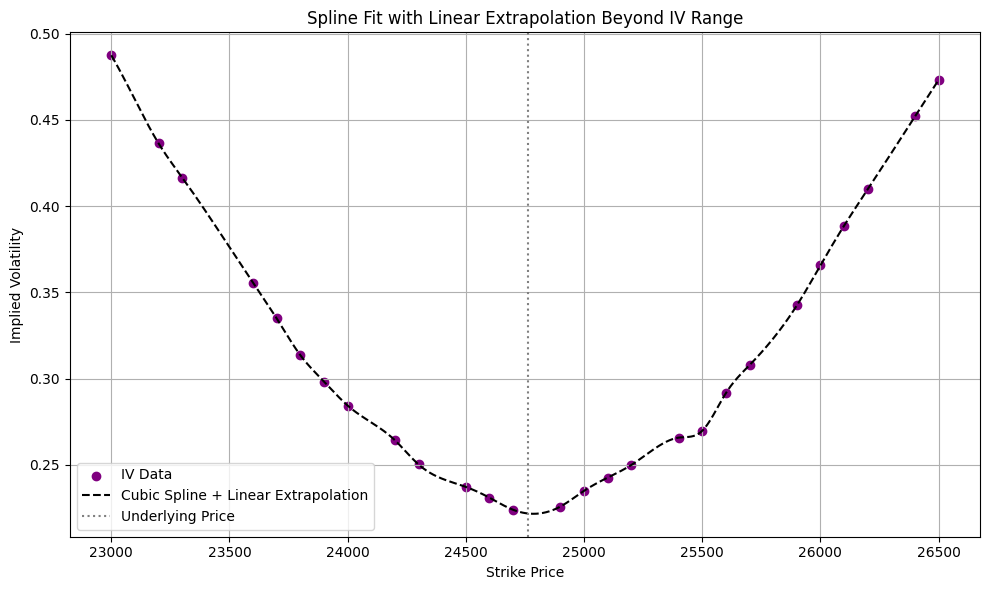

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.interpolate import CubicSpline

# Load data
df = pd.read_csv('test_data.csv')
row = df.iloc[995]  # Pick a row to analyze

# Extract IVs
iv_data = {}
for col in row.index:
    match = re.match(r'(call_iv_|put_iv_)(\d+)', col)
    if match:
        strike = int(match.group(2))
        iv = row[col]
        if pd.notna(iv):
            iv_data[strike] = iv

# Sort and convert to arrays
strikes, ivs = zip(*sorted(iv_data.items()))
strikes = np.array(strikes)
ivs = np.array(ivs)

# Underlying
underlying_price = row['underlying']

# Find closest point to underlying
idx_underlying = np.abs(strikes - underlying_price).argmin()
strike_underlying = strikes[idx_underlying]
iv_underlying = ivs[idx_underlying]

# Estimate endpoint slopes
slope_left = 1.5 * (iv_underlying - ivs[0]) / (strike_underlying - strikes[0])
slope_right = 1.5 * (ivs[-1] - iv_underlying) / (strikes[-1] - strike_underlying)

# Fit spline (interior only)
spline = CubicSpline(strikes, ivs, bc_type=((1, slope_left), (1, slope_right)), extrapolate=False)

# Smooth x range
x_smooth = np.linspace(23000, 26500, 1000)
y_smooth = np.empty_like(x_smooth)

# Linear extrapolation on left using first 2 points
s1, s2 = strikes[0], strikes[1]
iv1, iv2 = ivs[0], ivs[1]
slope_left_linear = (iv2 - iv1) / (s2 - s1)

# Linear extrapolation on right using last 2 points
sN_1, sN = strikes[-2], strikes[-1]
ivN_1, ivN = ivs[-2], ivs[-1]
slope_right_linear = (ivN - ivN_1) / (sN - sN_1)

# Fill y_smooth with appropriate values
for i, x in enumerate(x_smooth):
    if x < strikes[0]:
        y_smooth[i] = iv1 + slope_left_linear * (x - s1)
    elif x > strikes[-1]:
        y_smooth[i] = ivN + slope_right_linear * (x - sN)
    else:
        y_smooth[i] = spline(x)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(strikes, ivs, color='purple', label='IV Data')
plt.plot(x_smooth, y_smooth, color='black', linestyle='--', label='Cubic Spline + Linear Extrapolation')
plt.axvline(underlying_price, color='gray', linestyle=':', label='Underlying Price')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Spline Fit with Linear Extrapolation Beyond IV Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


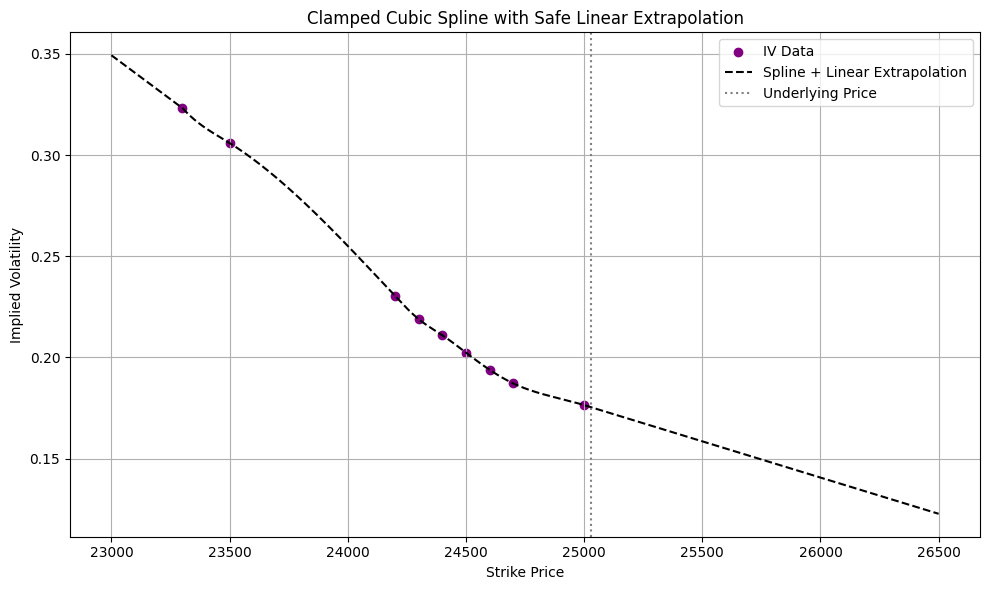

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.interpolate import CubicSpline

# Load data
df = pd.read_csv('test_data.csv')
row = df.iloc[5741]  # Pick a row to analyze

# Extract IVs
iv_data = {}
for col in row.index:
    match = re.match(r'(call_iv_|put_iv_)(\d+)', col)
    if match:
        strike = int(match.group(2))
        iv = row[col]
        if pd.notna(iv):
            iv_data[strike] = iv

# Sort and convert to arrays
strikes, ivs = zip(*sorted(iv_data.items()))
strikes = np.array(strikes)
ivs = np.array(ivs)

# Extract underlying price
underlying_price = row['underlying']
idx_underlying = np.abs(strikes - underlying_price).argmin()
strike_underlying = strikes[idx_underlying]
iv_underlying = ivs[idx_underlying]

# Robust slope estimation on left
for i in range(1, len(strikes)):
    if strikes[i] != strikes[0]:
        slope_left_linear = (ivs[i] - ivs[0]) / (strikes[i] - strikes[0])
        if strike_underlying != strikes[0]:
            slope_left = 1.5 * (iv_underlying - ivs[0]) / (strike_underlying - strikes[0])
        else:
            slope_left = slope_left_linear  # Fallback if division would be zero
        break

# Robust slope estimation on right
for i in range(1, len(strikes)):
    if strikes[-i - 1] != strikes[-1]:
        slope_right_linear = (ivs[-1] - ivs[-i - 1]) / (strikes[-1] - strikes[-i - 1])
        if strike_underlying != strikes[-1]:
            slope_right = 1.5 * (ivs[-1] - iv_underlying) / (strikes[-1] - strike_underlying)
        else:
            slope_right = slope_right_linear  # Fallback if division would be zero
        break

# Fit spline within range
spline = CubicSpline(strikes, ivs, bc_type=((1, slope_left), (1, slope_right)), extrapolate=False)

# Prepare evaluation range
x_smooth = np.linspace(23000, 26500, 1000)
y_smooth = np.empty_like(x_smooth)

# Linear extrapolation at edges
s1, iv1 = strikes[0], ivs[0]
sN, ivN = strikes[-1], ivs[-1]

for i, x in enumerate(x_smooth):
    if x < s1:
        y_smooth[i] = iv1 + slope_left_linear * (x - s1)
    elif x > sN:
        y_smooth[i] = ivN + slope_right_linear * (x - sN)
    else:
        y_smooth[i] = spline(x)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(strikes, ivs, color='purple', label='IV Data')
plt.plot(x_smooth, y_smooth, color='black', linestyle='--', label='Spline + Linear Extrapolation')
plt.axvline(underlying_price, color='gray', linestyle=':', label='Underlying Price')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Clamped Cubic Spline with Safe Linear Extrapolation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('test_data.csv')

# Filter columns that start with 'call_iv' or 'put_iv'
iv_columns = [col for col in df.columns if col.startswith('call_iv') or col.startswith('put_iv')]

# Subset the DataFrame to only those columns
iv_data = df[iv_columns]

# Count non-NA values per row in those columns
non_na_counts = iv_data.notna().sum(axis=1)

# Combine the counts with the original DataFrame to access timestamps
df_with_counts = df.copy()
df_with_counts['non_na_count'] = non_na_counts

# Sort by the non-NA count and get the top 5 rows with the fewest non-NAs
top5_min_rows = df_with_counts.sort_values('non_na_count').head(10)

# Print the top 5 minimum counts and their timestamps
print("Top 5 rows with the fewest non-NA 'call_iv'/'put_iv' values:")
print(top5_min_rows[['timestamp', 'non_na_count']])

top5_max_rows = df_with_counts.sort_values('non_na_count', ascending=False).head(10)

# Print the top 5 maximum counts and their timestamps
print("Top 5 rows with the most non-NA 'call_iv'/'put_iv' values:")
print(top5_max_rows[['timestamp', 'non_na_count']])


Top 5 rows with the fewest non-NA 'call_iv'/'put_iv' values:
      timestamp  non_na_count
9086       9086             8
2899       2899             9
2658       2658             9
5741       5741             9
6759       6759             9
6278       6278            10
5146       5146            10
8365       8365            10
8839       8839            10
413         413            10
Top 5 rows with the most non-NA 'call_iv'/'put_iv' values:
       timestamp  non_na_count
8908        8908            34
1121        1121            33
686          686            33
8781        8781            33
995          995            33
8179        8179            33
10003      10003            32
11682      11682            32
9748        9748            32
7451        7451            32


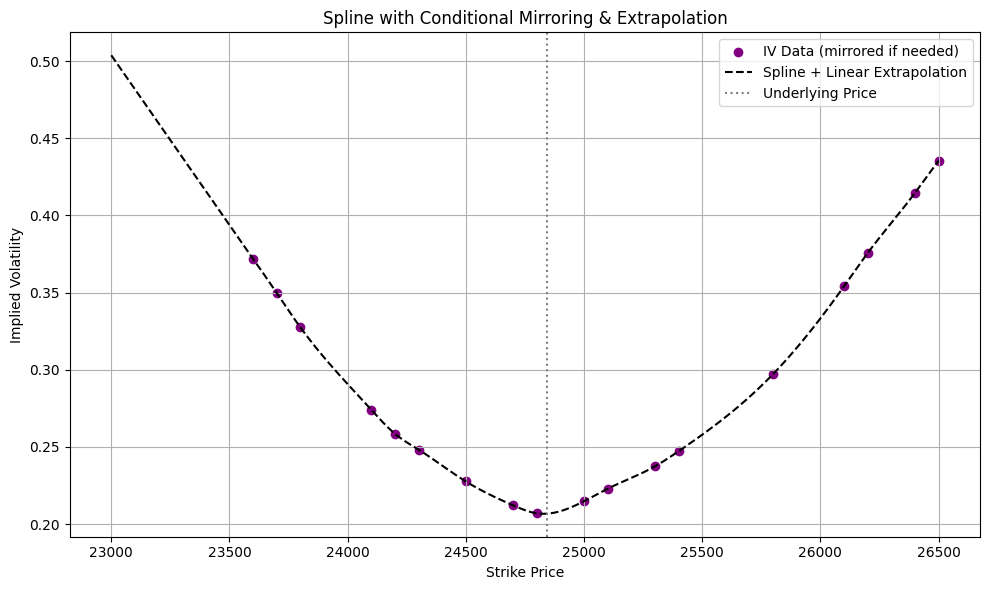

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.interpolate import CubicSpline

# Load data
df = pd.read_csv('test_data.csv')
row = df.iloc[1078]  # Pick a row to analyze

# Extract IVs
iv_data = {}
for col in row.index:
    match = re.match(r'(call_iv_|put_iv_)(\d+)', col)
    if match:
        strike = int(match.group(2))
        iv = row[col]
        if pd.notna(iv):
            iv_data[strike] = iv

# Sort and convert to arrays
strikes, ivs = zip(*sorted(iv_data.items()))
strikes = np.array(strikes)
ivs = np.array(ivs)

# Extract underlying price
underlying_price = row['underlying']
idx_underlying = np.abs(strikes - underlying_price).argmin()
strike_underlying = strikes[idx_underlying]
iv_underlying = ivs[idx_underlying]

# Count values on each side of underlying
left_mask = strikes < underlying_price
right_mask = strikes > underlying_price
num_left = np.sum(left_mask)
num_right = np.sum(right_mask)

# Mirror if fewer than 2 values on either side
if num_left < 2:
    mirror_strikes = 2 * underlying_price - strikes[right_mask]
    mirror_ivs = ivs[right_mask]
    strikes = np.concatenate([strikes, mirror_strikes])
    ivs = np.concatenate([ivs, mirror_ivs])
elif num_right < 2:
    mirror_strikes = 2 * underlying_price - strikes[left_mask]
    mirror_ivs = ivs[left_mask]
    strikes = np.concatenate([mirror_strikes, strikes])
    ivs = np.concatenate([mirror_ivs, ivs])

# Sort after mirroring
sorted_idx = np.argsort(strikes)
strikes = strikes[sorted_idx]
ivs = ivs[sorted_idx]

# Recompute underlying info
idx_underlying = np.abs(strikes - underlying_price).argmin()
strike_underlying = strikes[idx_underlying]
iv_underlying = ivs[idx_underlying]

# Estimate slope left
for i in range(1, len(strikes)):
    if strikes[i] != strikes[0]:
        slope_left_linear = (ivs[i] - ivs[0]) / (strikes[i] - strikes[0])
        if strike_underlying != strikes[0]:
            slope_left = 1.5 * (iv_underlying - ivs[0]) / (strike_underlying - strikes[0])
        else:
            slope_left = slope_left_linear
        break

# Estimate slope right
for i in range(1, len(strikes)):
    if strikes[-i - 1] != strikes[-1]:
        slope_right_linear = (ivs[-1] - ivs[-i - 1]) / (strikes[-1] - strikes[-i - 1])
        if strike_underlying != strikes[-1]:
            slope_right = 1.5 * (ivs[-1] - iv_underlying) / (strikes[-1] - strike_underlying)
        else:
            slope_right = slope_right_linear
        break

# Fit spline
spline = CubicSpline(strikes, ivs, bc_type=((1, slope_left), (1, slope_right)), extrapolate=False)

# Evaluate
x_smooth = np.linspace(23000, 26500, 1000)
y_smooth = np.empty_like(x_smooth)

s1, iv1 = strikes[0], ivs[0]
sN, ivN = strikes[-1], ivs[-1]

for i, x in enumerate(x_smooth):
    if x < s1:
        y_smooth[i] = iv1 + slope_left_linear * (x - s1)
    elif x > sN:
        y_smooth[i] = ivN + slope_right_linear * (x - sN)
    else:
        y_smooth[i] = spline(x)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(strikes, ivs, color='purple', label='IV Data (mirrored if needed)')
plt.plot(x_smooth, y_smooth, color='black', linestyle='--', label='Spline + Linear Extrapolation')
plt.axvline(underlying_price, color='gray', linestyle=':', label='Underlying Price')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Spline with Conditional Mirroring & Extrapolation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
